---------------------------
#### Query Expansion
----------------------

**Query Expansion** refers to the process of improving a search query by adding additional terms to make it more comprehensive and improve the retrieval of relevant documents or information. This technique helps bridge the gap between the user's search terms and the language used in the target documents, ultimately enhancing search accuracy.

1. **Synonym-based Expansion**:
   Adding synonyms or related terms to the original query.
   
   ```text
   Original Query: "car"
   Expanded Query: "car OR automobile OR vehicle"

2. **Context-based Expansion**: Expanding the query by adding terms related to the context of the search.
   ```text
   Original Query: "cloud"
   Expanded Query: "cloud computing OR cloud storage OR cloud infrastructure"

3. **Relevance Feedback**: After showing initial results, users can provide feedback on relevant documents, and the system expands the query accordingly.
    ```text
    Original Query: "neural network"
    Expanded Query (after relevance feedback): "neural network OR deep learning OR backpropagation"

4. **Pseudo-Relevance Feedback**: The system assumes that the top-ranked results are relevant and uses terms from them to expand the query automatically.

In [1]:
from helper_utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

In [17]:
# takes abt 3 mins
embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename          = r'./data/microsoft_annual_report_2022.pdf', 
                                collection_name   = 'microsoft_annual_report_2022', 
                                embedding_function= embedding_function)
chroma_collection.count()

D:\ANACONDA\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


349

In [8]:
import os, pickle
import openai
from openai import OpenAI

In [4]:
openai.api_key = os.environ['OPENAI_API_KEY']

In [5]:
openai_client = OpenAI()

#### Expansion with generated answers

https://arxiv.org/abs/2305.03653

In [6]:
import umap

initialize a UMAP model

In [21]:
embeddings     = chroma_collection.get(include=['embeddings'])['embeddings']

umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

D:\ANACONDA\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
# projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

In [9]:
with open('projected_embeddings.pkl', 'rb') as f:
    projected_dataset_embeddings = pickle.load(f)

In [10]:
def augment_query_generated(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. \
                        Provide an example answer to the given question, that \
                        might be found in a document like an annual report. "
        },
        {"role": "user", "content": query}
    ] 

    response = openai_client.chat.completions.create(
        model   = model,
        messages= messages,
    )
    content = response.choices[0].message.content
    return content

In [11]:
original_query = "Was there significant turnover in the executive team?"

In [14]:
hypothetical_answer = augment_query_generated(original_query)
hypothetical_answer

"During the fiscal year, there was no significant turnover in the executive team. The leadership team remained stable, with key executives continuing to drive the company's strategic initiatives forward. The consistent presence of top-level management has provided valuable continuity in decision-making and operational oversight."

In [15]:
joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

Was there significant turnover in the executive team? During the fiscal
year, there was no significant turnover in the executive team. The
leadership team remained stable, with key executives continuing to
drive the company's strategic initiatives forward. The consistent
presence of top-level management has provided valuable continuity in
decision-making and operational oversight.


In [18]:
results = chroma_collection.query(query_texts = joint_query, 
                                  n_results   = 5, 
                                  include     = ['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(word_wrap(doc))
    print('')

unresolved with the irs, evaluating management ’ s estimates relating
to their determination of uncertain tax positions required extensive
audit effort and a high degree of auditor judgment, including
involvement of our tax specialists. how the critical audit matter was
addressed in the audit our principal audit procedures to evaluate
management ’ s estimates of uncertain tax positions related to
unresolved transfer pricing issues included the following : • we
evaluated the appropriateness and consistency of management ’ s methods
and assumptions used in the identification, recognition, measurement,
and disclosure of uncertain tax positions, which included testing the
effectiveness of the related internal controls. • we read and evaluated
management ’ s documentation, including relevant accounting policies
and information obtained by management from outside tax specialists,
that detailed the basis of the uncertain tax positions.

87 changes in and disagreements with accountants on acco

In [22]:
%%time
retrieved_embeddings      = results['embeddings'][0]

original_query_embedding  = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding  = project_embeddings(original_query_embedding,  umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)

projected_retrieved_embeddings      = project_embeddings(retrieved_embeddings, umap_transform)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.44it/s]

CPU times: total: 2.5 s
Wall time: 7.74 s


(-2.6169466614723205,
 8.120241367816925,
 2.8080547571182253,
 10.272378611564637)

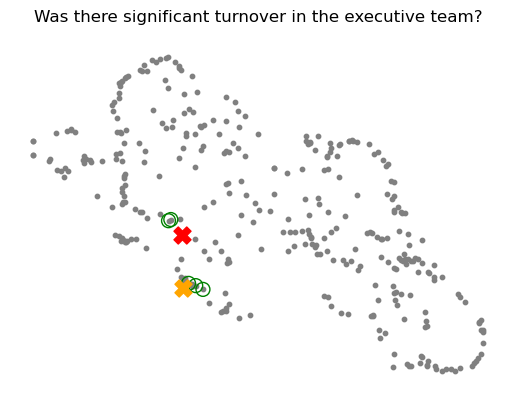

In [23]:
import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0],   projected_dataset_embeddings[:, 1],   s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.scatter(projected_original_query_embedding[:, 0],  projected_original_query_embedding[:, 1],  s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

**Observation**
- RED    - Original query
- Orange - Augmented Query
- cluster of documents around the augmented query (which is desirable)

#### Expansion with multiple queries

In [24]:
def augment_multiple_query(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. \
                        Your users are asking questions about an annual report. "\
                        "Suggest up to five additional related questions to help them \
                        find the information they need, for the provided question. "\
                        "Suggest only short questions without compound sentences. \
                        Suggest a variety of questions that cover different aspects of the topic."\
                        "Make sure they are complete questions, and that they are related \
                        to the original question."\
                        "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [25]:
original_query = "What were the most important factors that contributed to increases in revenue?"

In [26]:
augmented_queries = augment_multiple_query(original_query)
augmented_queries

["- How did the company's revenue compare to the previous fiscal year?",
 '- Were there any significant changes in product pricing that impacted revenue growth?',
 '- Can you provide details on which product lines or segments saw the highest revenue growth?',
 '- Did the company expand into new markets or geographical regions that positively affected revenue?',
 '- Were there any strategic partnerships or acquisitions that influenced the revenue increase?']

In [27]:
for query in augmented_queries:
    print(query)

- How did the company's revenue compare to the previous fiscal year?
- Were there any significant changes in product pricing that impacted revenue growth?
- Can you provide details on which product lines or segments saw the highest revenue growth?
- Did the company expand into new markets or geographical regions that positively affected revenue?
- Were there any strategic partnerships or acquisitions that influenced the revenue increase?


In [28]:
queries = [original_query] + augmented_queries

queries

['What were the most important factors that contributed to increases in revenue?',
 "- How did the company's revenue compare to the previous fiscal year?",
 '- Were there any significant changes in product pricing that impacted revenue growth?',
 '- Can you provide details on which product lines or segments saw the highest revenue growth?',
 '- Did the company expand into new markets or geographical regions that positively affected revenue?',
 '- Were there any strategic partnerships or acquisitions that influenced the revenue increase?']

In [30]:
results = chroma_collection.query(query_texts= queries, 
                                  n_results  = 5, 
                                  include    = ['documents', 'embeddings'])


In [31]:
retrieved_documents = results['documents']

> Note : Since the queries are related, we may get the same doc in the results (may be)

In [32]:
# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

In [33]:
for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
engineering, gaming, and linkedin. • sales and marketing expenses
increased $ 1. 7 billion or 8 % driven by investments in commercial
sales and linkedin. sales and marketing included a favorable foreign
currency impact of 2 %. • general and administrative expenses increased
$ 793 million or 16 % driven by investments in corporate functions.
operating income increased $ 13. 5 billion or 19 % driven by growth
across each of our segments. current year net income and diluted eps
were positively impacted by the net tax benefit related to the transfer
of intangible properties, which resulted in an increase to net income
and diluted eps of $ 3. 3 billion and $ 0. 44, respectively. prior year
net income and diluted eps were positively impacted by the net tax
benefit related to the india supreme court decision on withholding
taxes, which resulted in an increase to net income and diluted eps of $
620 

In [34]:
original_query_embedding   = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query    = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.27it/s]


In [35]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)


100%|█████████████████████████████████████████████████████████████████████████| 30/30 [00:23<00:00,  1.30it/s]


(-2.6169466614723205,
 8.120241367816925,
 2.8080547571182253,
 10.272378611564637)

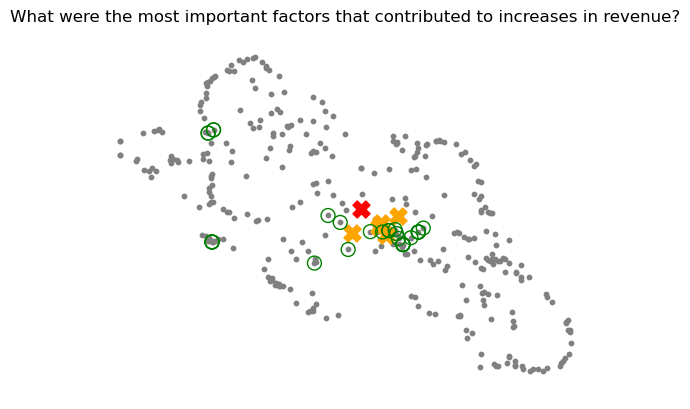

In [36]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

**Observation**

- Original Query might not have got the wide (diverse) related documents in the search
- with multiple queries, we get a diverse set of documents

This is useful for a COMPLEX query

__Disadvantage__ is : with more results, we are not sure which of these documents are more relevant

- Use of Cross Encoders